### Construct a Confidence Interval as a Post-process release


In [ ]:
from scipy.stats import norm

# established in previous lectures
from mock_dp_library import *


def ci_postprocess(release, n, bounds, epsilon, delta, alpha=0.05):
	"""Confidence interval for mean release, assuming gaussian noise."""
	lower, upper = bounds
	sensitivity = (upper - lower) / n
	scale = (sensitivity / epsilon) * np.sqrt(2 * np.log(2 / delta))
    
	ci_radius = norm.ppf(1 - (alpha / 2), scale=scale)
	ci_lower_bound = release - ci_radius
	ci_upper_bound = release + ci_radius
    
	return {"lower": ci_lower_bound, "upper": ci_upper_bound}


def ci_mean_release(x, bounds, epsilon, delta, alpha=0.05):
	"""Differentially private mean release with confidence interval metadata.
	Assumes that the dataset size is public."""
	dp_mean = release_dp_mean(x, bounds, epsilon, delta=delta, mechanism="gaussian")

	return {
		"mean": dp_mean, 
		"true": bounded_mean(x, bounds), 
		**ci_postprocess(release=dp_mean, n=len(x), bounds=bounds, epsilon=epsilon, delta=delta, alpha=alpha)
	}

### Show performance individually for a set of confidence intervals

In [ ]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

# we are demonstrating only on the educ variable
bounds = (1., 16.)
data = data['educ'].values

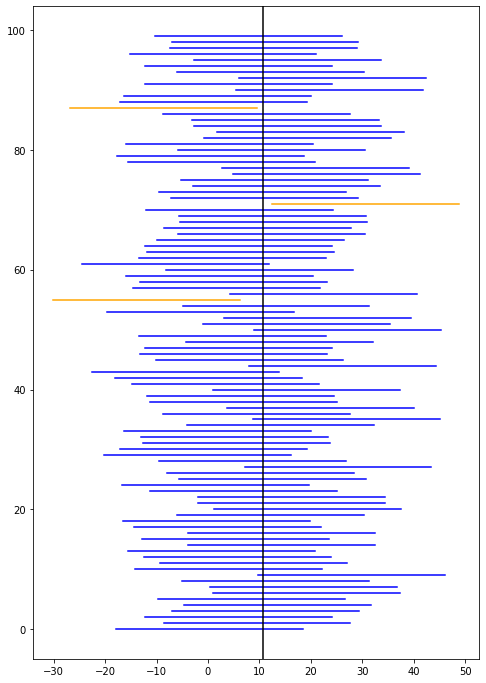

In [ ]:
import matplotlib.pyplot as plt

bootdata = bootstrap(x=data, n=100)
n_sims = 100
epsilon = 0.1
delta = 1e-8
# 95% of DP CI's should cover the sample mean
alpha = 0.05

plt.figure(figsize=(8, 12))
for i in range(n_sims):
    trial = ci_mean_release(x=bootdata, bounds=bounds, epsilon=epsilon, delta=delta, alpha=alpha)

    covers = trial["lower"] < trial["true"] and trial["upper"] > trial["true"]
    plt.plot((trial['lower'], trial['upper']), (i, i), '-', color="blue" if covers else "orange")

plt.axvline(x=trial["true"], color="black")



In [ ]:
n_sims = 1000
population_true = data.mean(axis=0)
plt.rcParams['figure.figsize'] = [10,10]


def simulate_coverage(epsilon, delta, sample_size, alpha):
	coverages = []
	for j in range(n_sims): 
		bootdata = bootstrap(x=data, n=sample_size)
		ci_sim = ci_mean_release(x=bootdata, bounds=bounds, epsilon=epsilon, delta=delta, alpha=alpha)
		#covers_true = ci_sim["lower"] < population_true and ci_sim["upper"] > population_true # We are not covering population truth
		covers_true = ci_sim["lower"] < ci_sim["true"] and ci_sim["upper"] > ci_sim["true"]  # We are covering sample result
		coverages.append(covers_true)

	return np.mean(coverages)
	
# even steps in logarithmic space, rounded to 2 decimals
ep_seq = np.around(np.logspace(start=np.log10(1), stop=np.log10(0.1), num=50), decimals=2)
sample_size = 500

agghistory = []
for epsilon in ep_seq:
	agghistory.append({"epsilon": epsilon, "coverage": simulate_coverage(epsilon, delta, sample_size, alpha)})
agghistory = pd.DataFrame(agghistory)


# even steps in logarithmic space
n_seq = np.logspace(start=np.log10(200), stop=np.log10(1500), num=15).astype(int)
epsilon = 0.1

agghistory2 = []
for sample_size in n_seq:
	agghistory2.append({"sample size": sample_size, "coverage": simulate_coverage(epsilon, delta, sample_size, alpha)})
agghistory2 = pd.DataFrame(agghistory2)



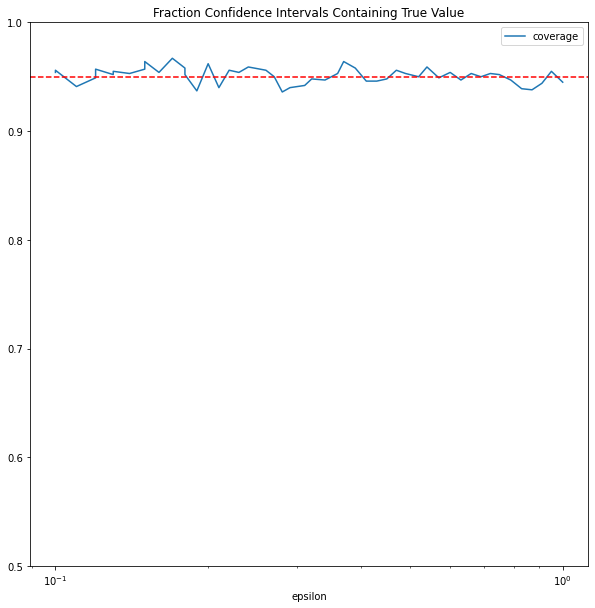

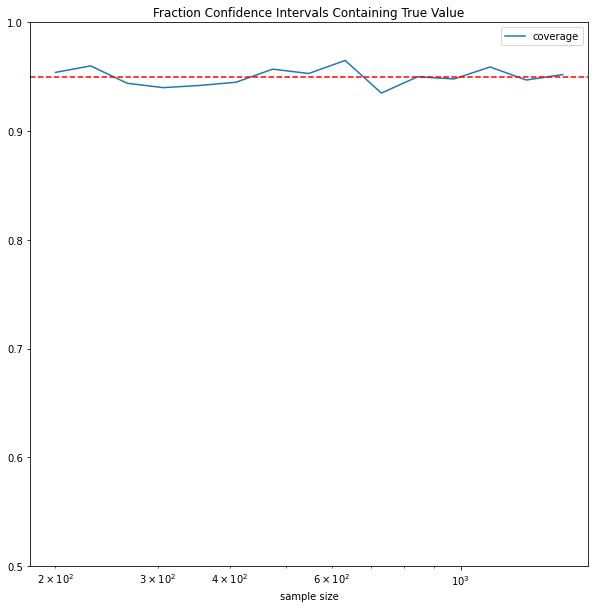

In [ ]:
agghistory.plot(x="epsilon", y="coverage", ylim=(0.5, 1), logx=True,
                title="Fraction Confidence Intervals Containing True Value")
plt.axhline(0.95, color="red", linestyle='--')

agghistory2.plot(x="sample size", y="coverage", ylim=(0.5, 1), logx=True,
                title="Fraction Confidence Intervals Containing True Value")
plt.axhline(0.95, color="red", linestyle='--')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>